# Geometric Multigrid



<IPython.core.display.Javascript object>


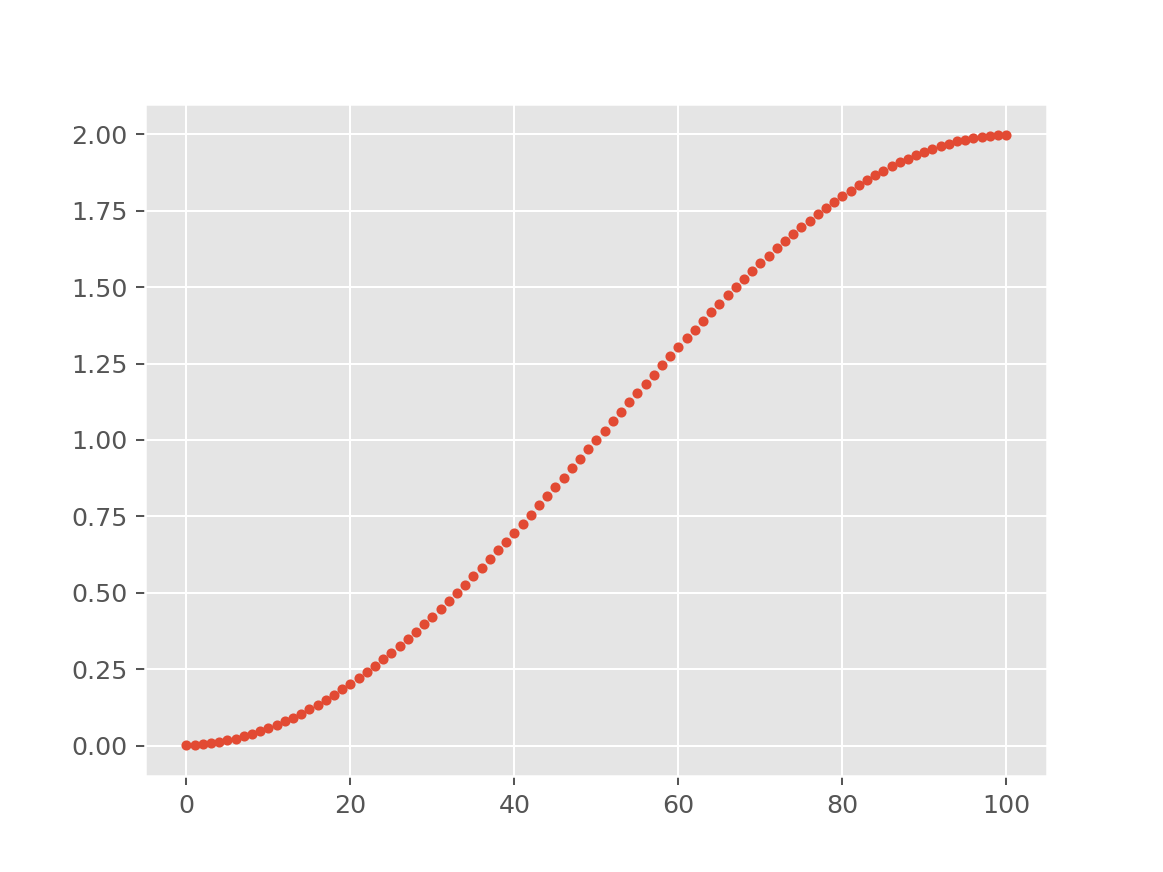

[ 0.00047428  0.00189667  0.00426582  0.00757949] [ 1.99242051  1.99573418  1.99810333  1.99952572]
cond 4215.9157276


In [1]:
%matplotlib notebook
import numpy

m = 101
A = numpy.eye(m) - .5*numpy.eye(m,k=1) - .5*numpy.eye(m,k=-1)

I = numpy.eye(m)
L, X  = numpy.linalg.eigh(A)

from matplotlib import pyplot
pyplot.style.use('ggplot')
pyplot.figure()
pyplot.plot(L, '.')
pyplot.show()

print(L[:4], L[-4:])
print('cond', L[-1]/L[0])

<IPython.core.display.Javascript object>


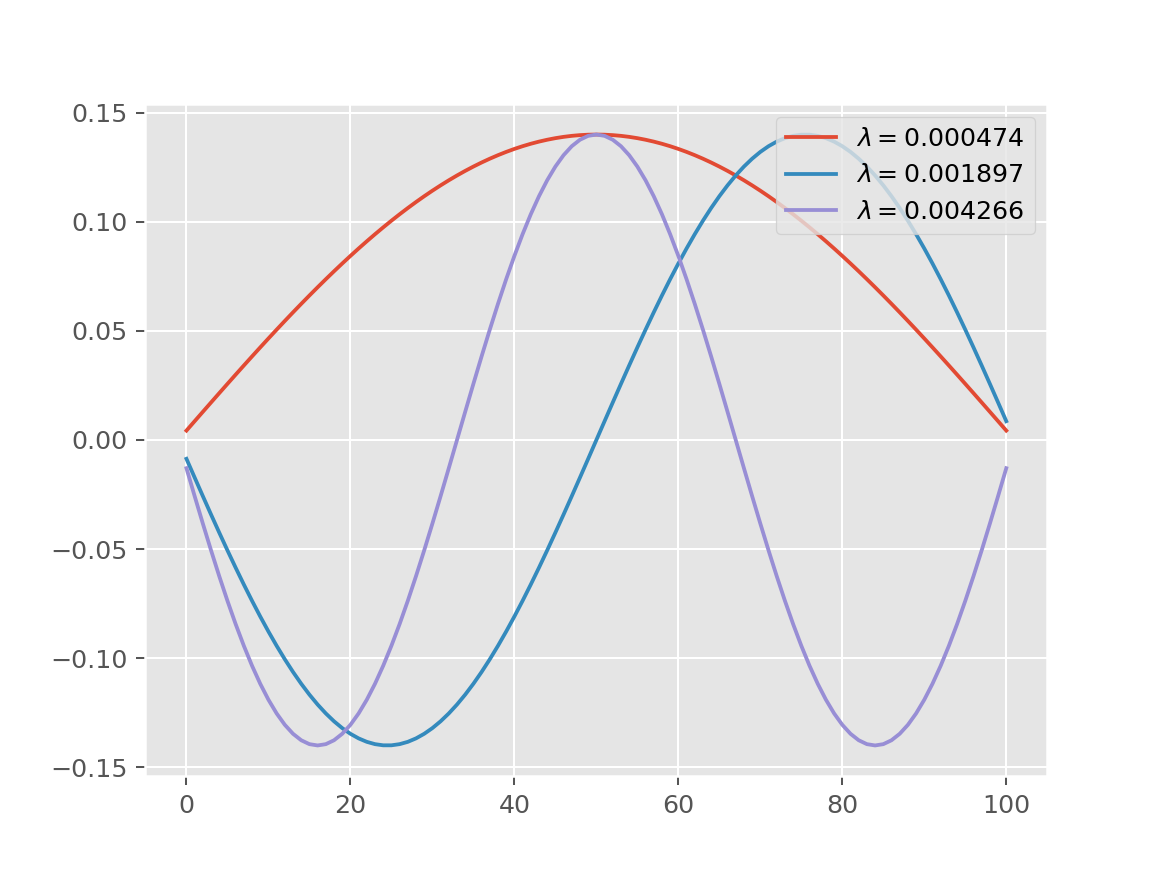

In [2]:
pyplot.figure()
for i in (0,1,2):
    pyplot.plot(X[:,i], label='$\lambda = %f$' % L[i])
pyplot.legend(loc='upper right')
pyplot.show()

<IPython.core.display.Javascript object>


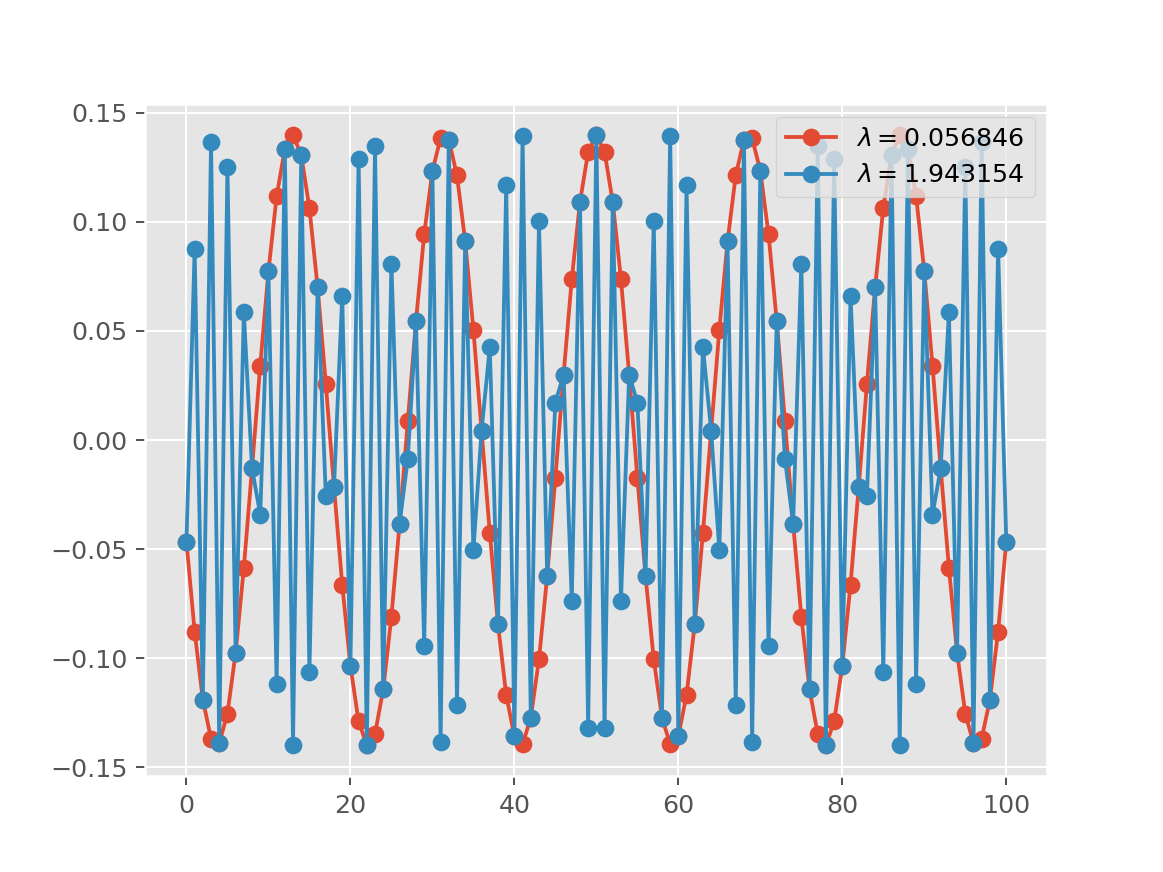

In [3]:
pyplot.figure()
for i in (10,90):
    pyplot.plot(X[:,i], '-o', label='$\lambda = %f$' % L[i])
pyplot.legend(loc='upper right')
pyplot.show()

<IPython.core.display.Javascript object>


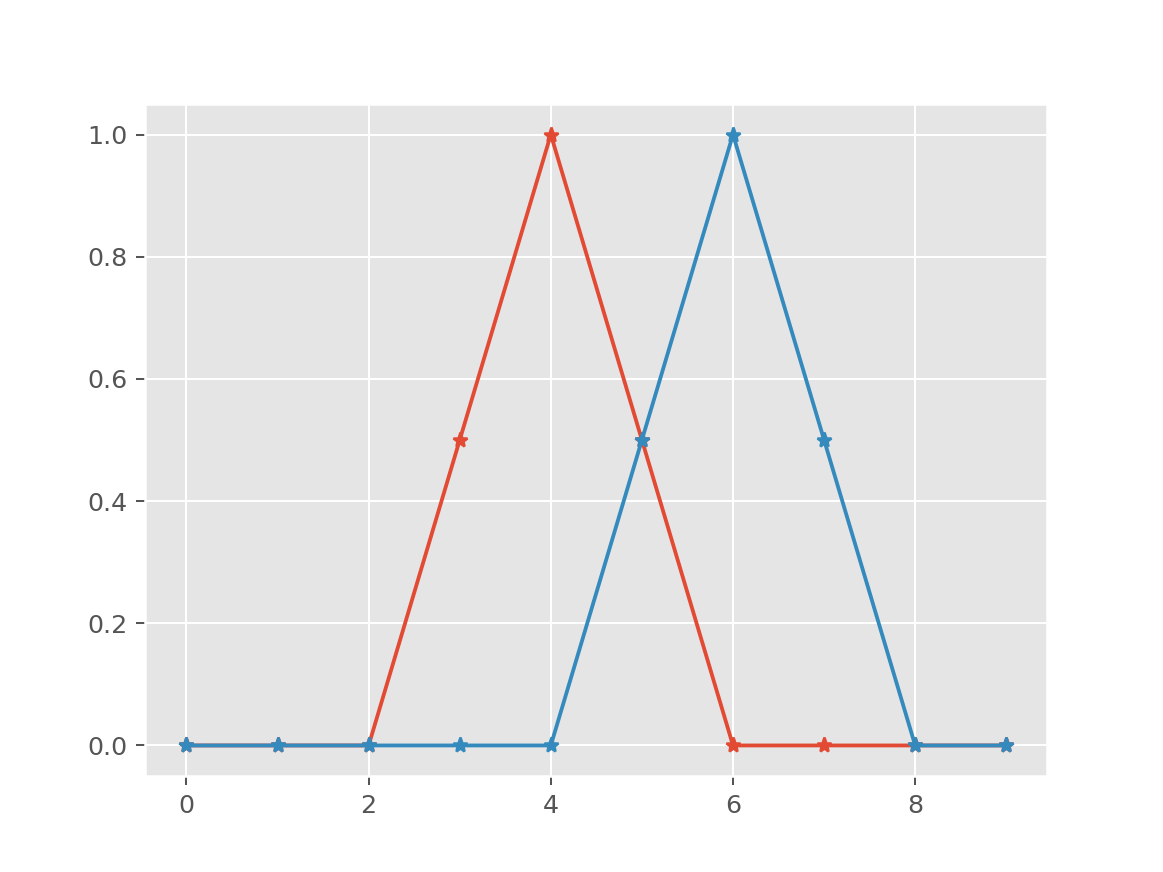

(101, 51)

In [4]:
P = numpy.eye(m) + .5*numpy.eye(m,k=1) + .5*numpy.eye(m,k=-1)
P = P[:,::2]
#P = numpy.eye(m) + 2./3*(numpy.eye(m,k=1)+numpy.eye(m,k=-1)) + \
#    1./3*(numpy.eye(m,k=2)+numpy.eye(m,k=-2))
#P = P[:,::3]

pyplot.figure()
pyplot.plot(P[:10,2:4], '-*')

P.shape

<IPython.core.display.Javascript object>


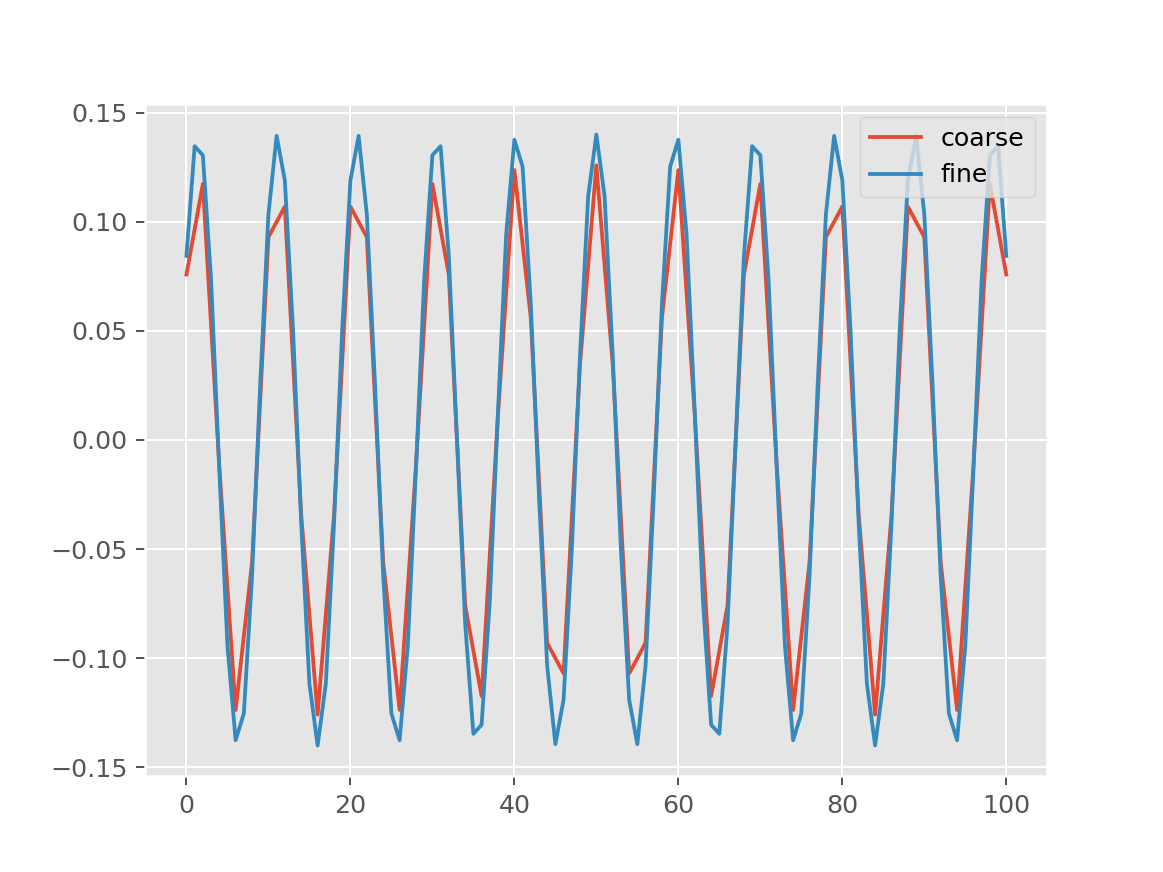

In [5]:
pyplot.figure()
pyplot.plot(1./2*P.dot(P.T.dot(X[:,20])), label='coarse')
pyplot.plot(X[:,20], label='fine')
pyplot.legend(loc='upper right')

(51, 51)


<IPython.core.display.Javascript object>


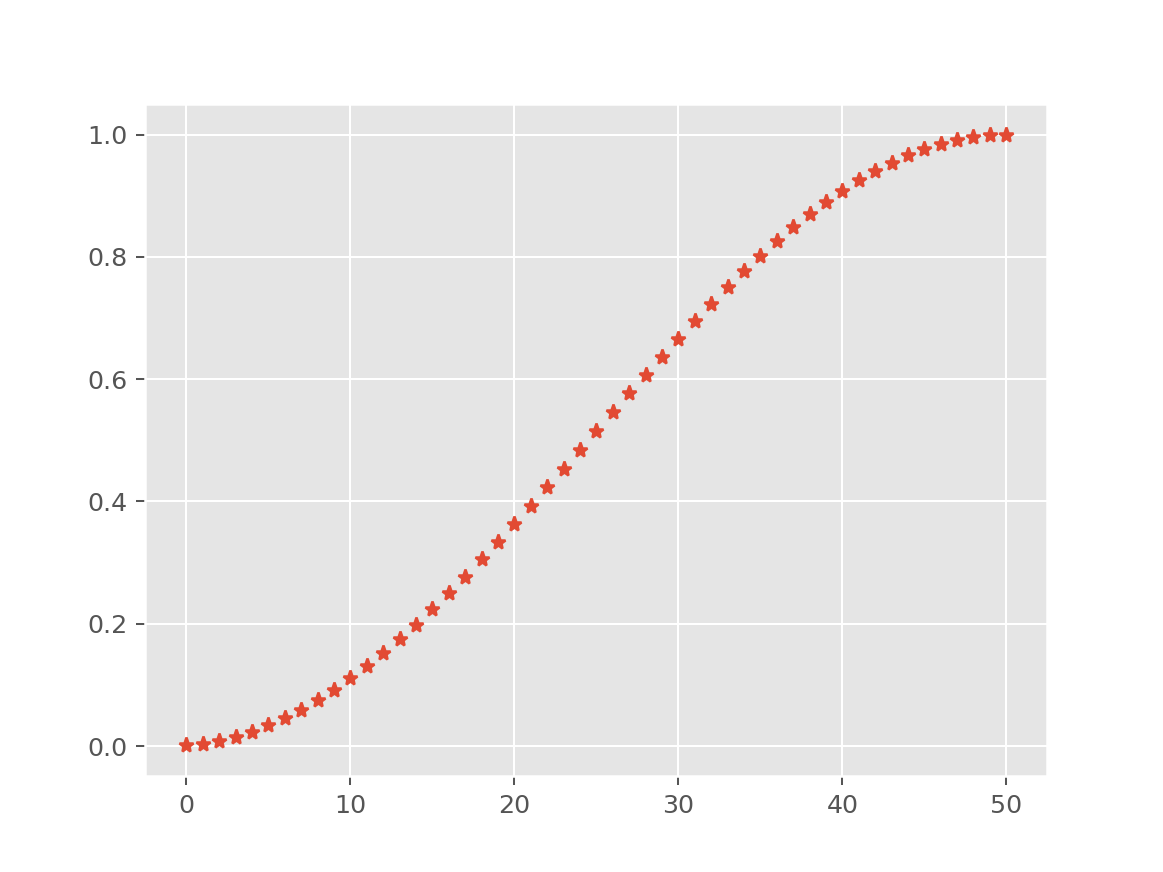

In [6]:
Ac = P.T.dot(A.dot(P))
print(Ac.shape)

Lc, Xc = numpy.linalg.eigh(Ac)
pyplot.figure()
pyplot.plot(Lc, '*')

<IPython.core.display.Javascript object>


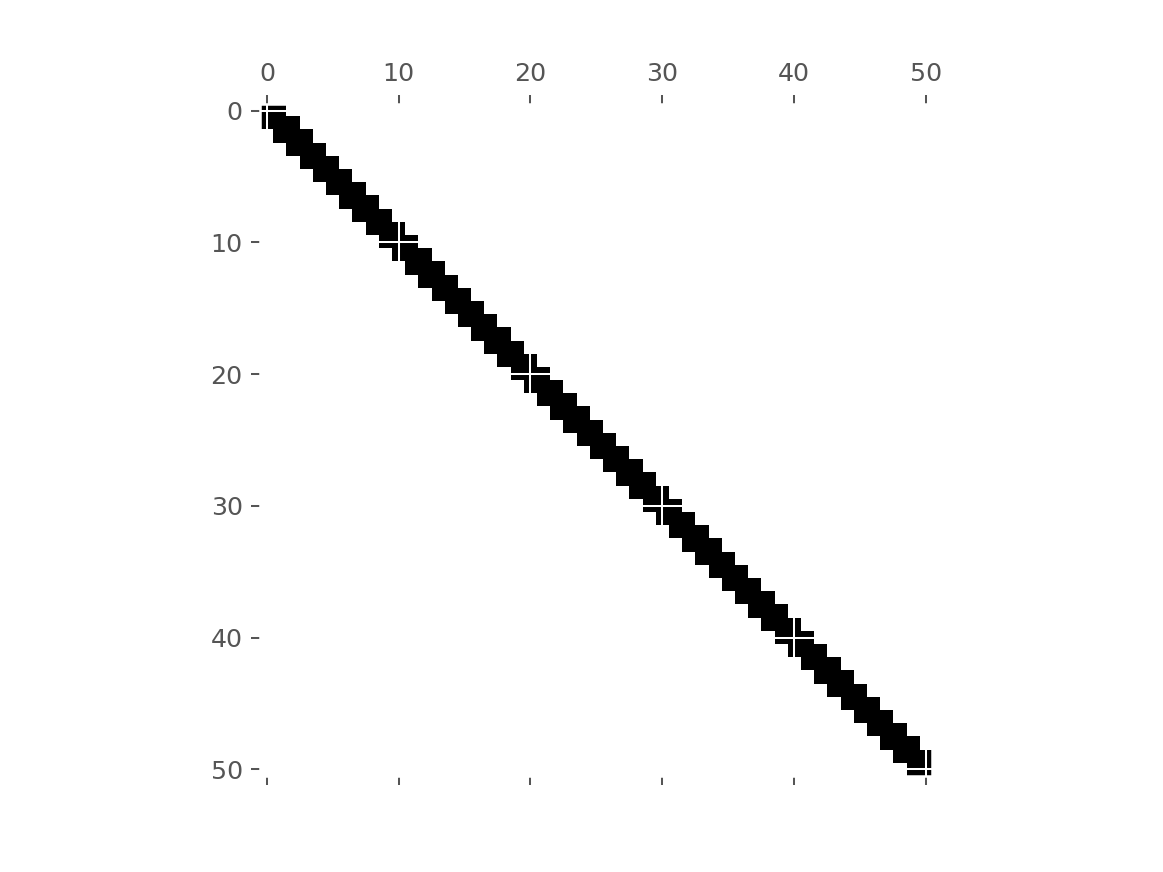

array([[ 0.75, -0.25,  0.  ,  0.  ,  0.  ],
       [-0.25,  0.5 , -0.25,  0.  ,  0.  ],
       [ 0.  , -0.25,  0.5 , -0.25,  0.  ],
       [ 0.  ,  0.  , -0.25,  0.5 , -0.25],
       [ 0.  ,  0.  ,  0.  , -0.25,  0.5 ]])

In [7]:
pyplot.figure()
pyplot.spy(Ac)
Ac[:5,:5]

7.18533924784e-15


<IPython.core.display.Javascript object>


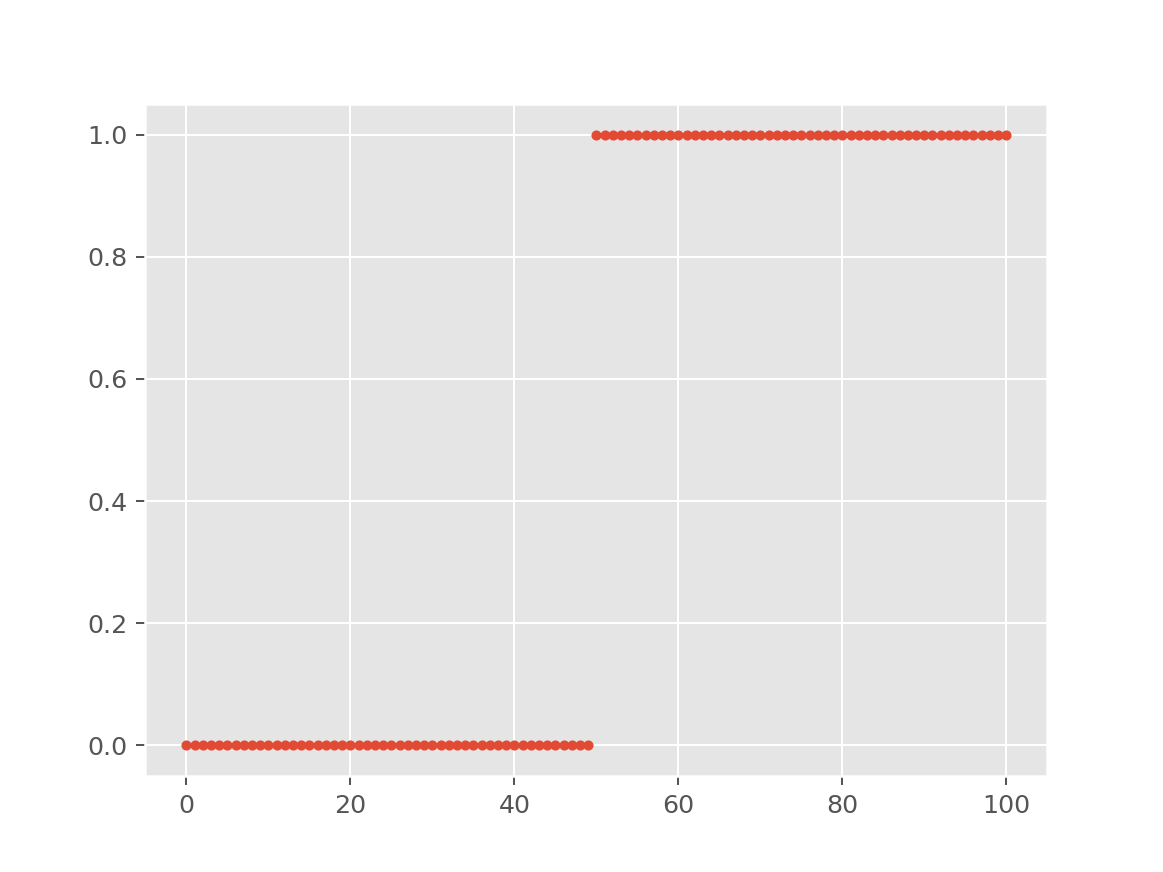

In [8]:
# Consider the A-orthogonal projector into the range of P
Sc = P.dot(numpy.linalg.inv(Ac)).dot(P.T).dot(A)
Ls, Xs = numpy.linalg.eig(Sc)
print(max(abs(Ls.imag)))
Ls = Ls.real
idx = Ls.argsort()
Ls = Ls[idx]; Xs = Xs[:,idx]

pyplot.figure()
pyplot.plot(Ls, '.')

<IPython.core.display.Javascript object>


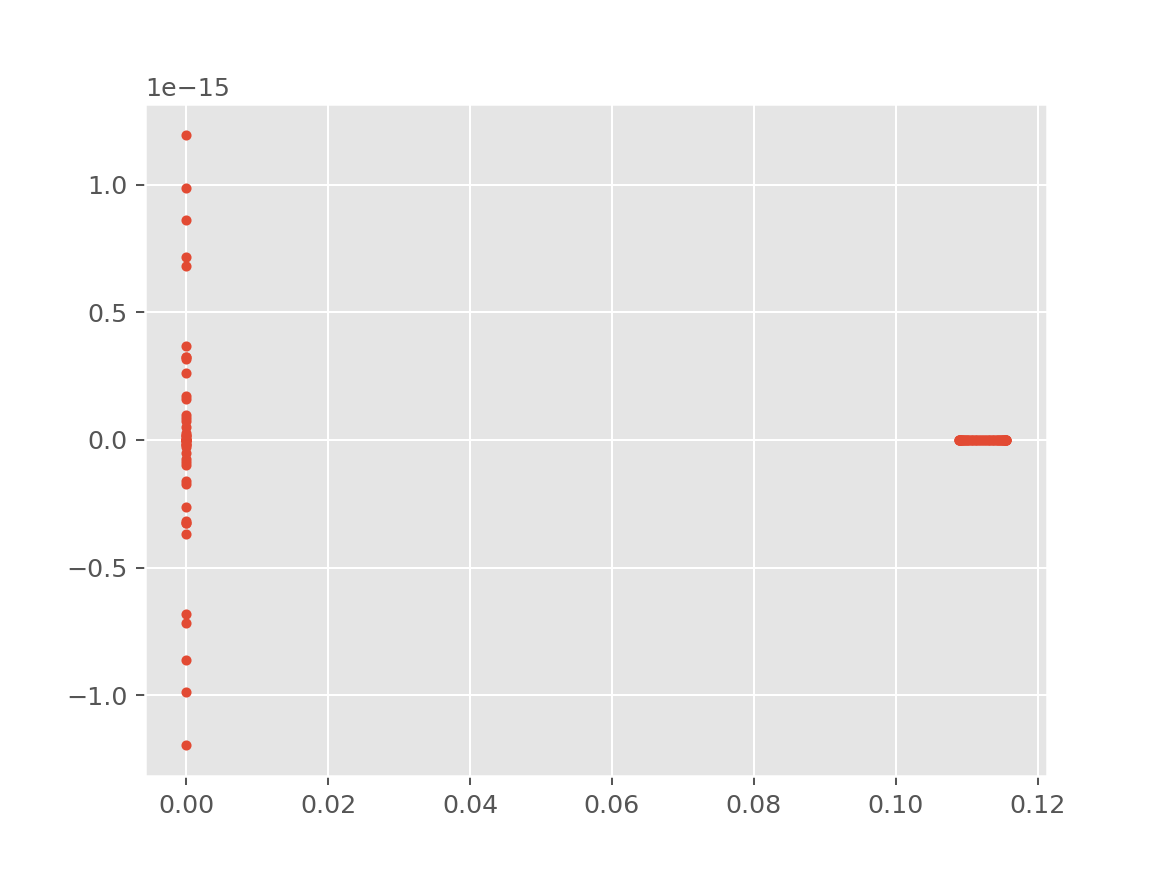

In [9]:
# Iteration matrix for a V(1,1) cycle
Lt, Xt = numpy.linalg.eig((I - .67*A).dot(I - Sc).dot(I - .67*A))
pyplot.figure()
pyplot.plot(Lt.real, Lt.imag, '.')

### Choices for linear multigrid
* Smoother
* Interpolation $P$ (coarse basis)
* Restriction ($P^T$, or different for non-symmetric problems)
* Coarse operator (Galerkin $P^T A P$, rediscretization)

## Multigrid as factorization

We can interpret factorization as a particular multigrid or domain decomposition method.

We can partition an SPD matrix as
$$J = \begin{bmatrix} A & B^T \\ B & D \end{bmatrix}$$
and define the preconditioner by the factorization
$$      M = \begin{bmatrix} I & \\ B A^{-1} & I \end{bmatrix}
      \begin{bmatrix} A &  \\ & S \end{bmatrix}
      \begin{bmatrix} I & A^{-1}B^T \\  & I \end{bmatrix}
$$
where $S = D - B A^{-1} B^T$.  $M$ has an inverse
$$      M^{-1} =
      \begin{bmatrix} I & -A^{-1}B^T \\  & I \end{bmatrix}
      \begin{bmatrix} A^{-1} &  \\ & S^{-1} \end{bmatrix}
      \begin{bmatrix} I & \\ -B A^{-1} & I \end{bmatrix} .
$$
Define the interpolation
$$ P_f = \begin{bmatrix} I \\ 0 \end{bmatrix}, \quad P_c = \begin{bmatrix} -A^{-1} B^T \\ I \end{bmatrix} $$ and rewrite as
$$ M^{-1} = [P_f\  P_c] \begin{bmatrix} A^{-1} P_f^T \\ S^{-1} P_c^T \end{bmatrix} = P_f A^{-1} P_f^T + P_c S^{-1} P_c^T.$$
The iteration matrix is thus
$$ I - M^{-1} J = I - P_f A^{-1} P_f^T J - P_c S^{-1} P_c^T J .$$

<IPython.core.display.Javascript object>


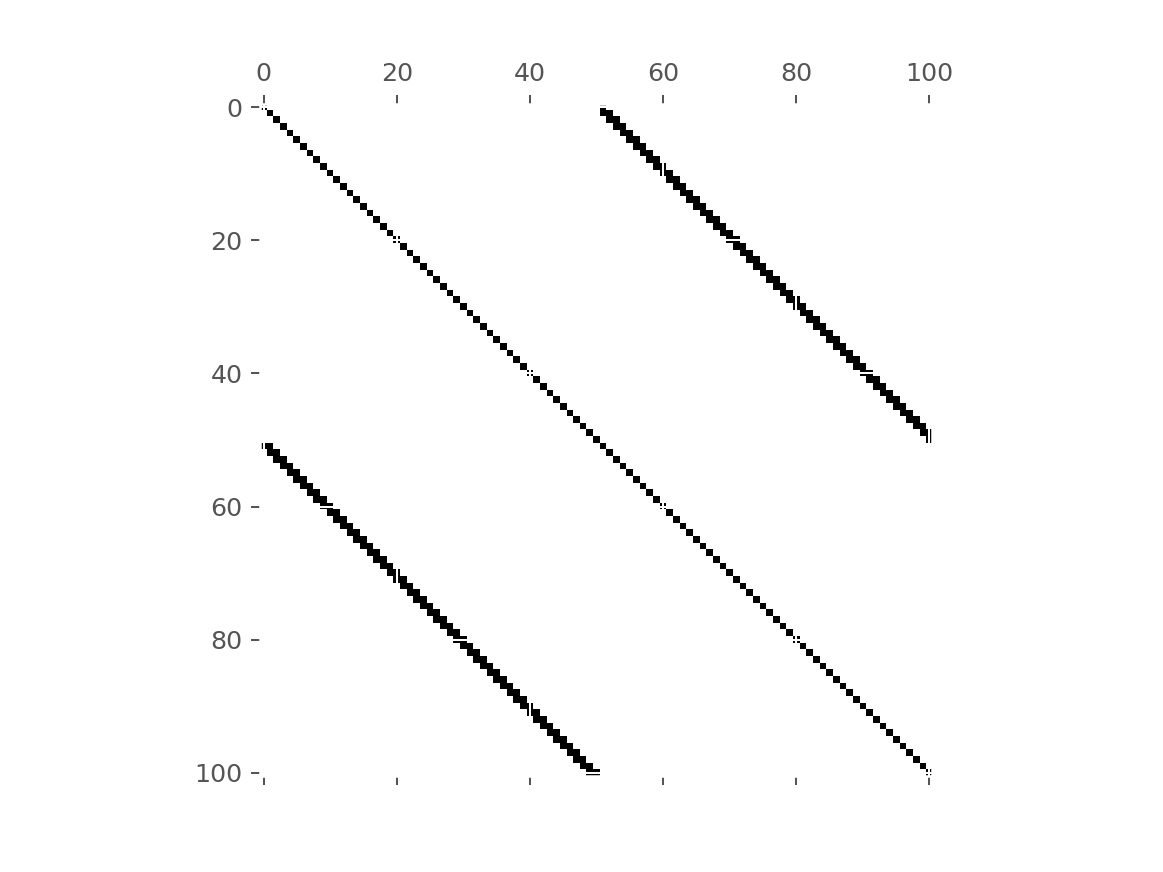

In [10]:
idx = numpy.concatenate((numpy.arange(0,m,2), numpy.arange(1,m,2)))
J = A[:,idx][idx,:]
pyplot.figure()
pyplot.spy(J)

<IPython.core.display.Javascript object>


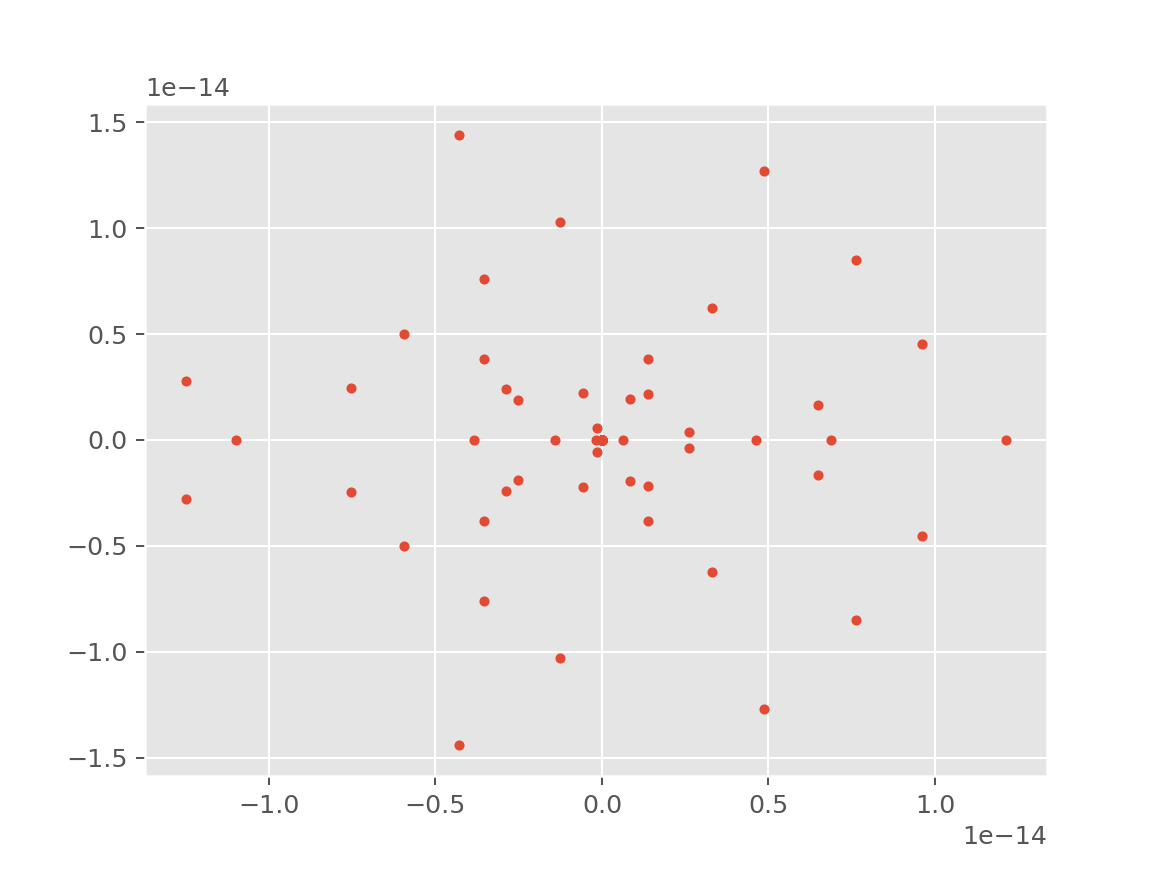

In [11]:
mf = m // 2 + 1
Pf = numpy.concatenate((numpy.eye(mf), numpy.zeros((m-mf, mf))))
Jf = Pf.T.dot(J.dot(Pf))
Pc = numpy.concatenate((-numpy.linalg.inv(Jf).dot(J[:mf,mf:]), numpy.eye(m-mf)))
Jc = Pc.T.dot(J.dot(Pc))

Mf = Pf.dot(numpy.linalg.inv(Jf)).dot(Pf.T)
Mc = Pc.dot(numpy.linalg.inv(Jc)).dot(Pc.T)
T = I - (Mf + Mc).dot(J)
T = (I - Mf.dot(J)).dot(I - Mc.dot(J))
#T = (I - .67*J).dot(I - Mc.dot(J))
#T = I - .67*J - Mc.dot(J)
Lt, Xt = numpy.linalg.eig(T)
pyplot.figure()
pyplot.plot(Lt.real, Lt.imag, '.')

<IPython.core.display.Javascript object>


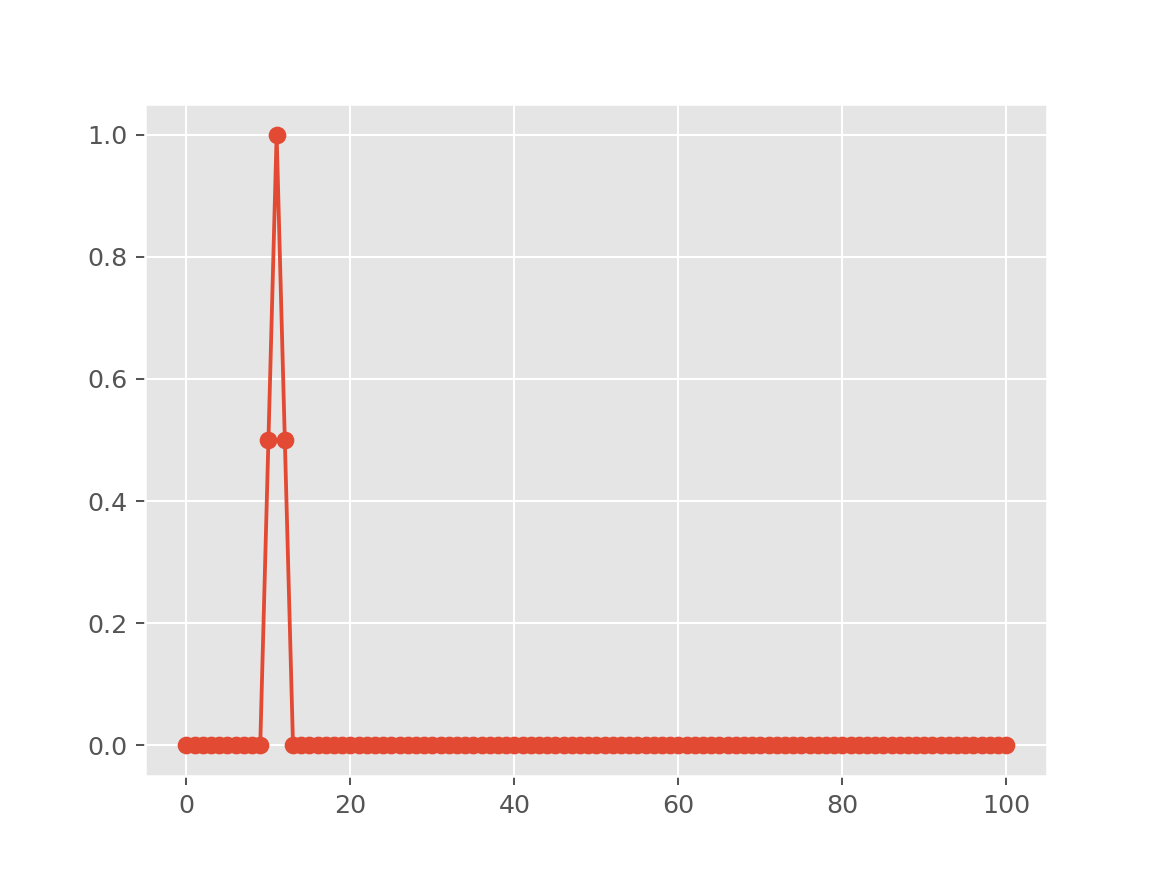

In [12]:
# Invert the permutation
idxinv = numpy.zeros(m, dtype=int)
idxinv[idx] = numpy.arange(m)

# Plot the coarse basis function in the original ordering
pyplot.figure()
pyplot.plot(Pc[:,5][idxinv], '-o')